# ADS 509 Assignment 2.1: Tokenization, Normalization, Descriptive Statistics 

This notebook holds Assignment 2.1 for Module 2 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In the previous assignment you pulled lyrics data on two artists. In this assignment we explore this data set and a pull from the now-defunct Twitter API for the artists Cher and Robyn.  If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Canvas. 

This assignment asks you to write a short function to calculate some descriptive statistics on a piece of text. Then you are asked to find some interesting and unique statistics on your corpora. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
import nltk
from nltk.corpus import stopwords
from string import punctuation

sw = stopwords.words("english")

In [2]:
import string

In [3]:
# change `data_location` to the location of the folder on your machine.
data_location = "/Users/mtc/ADS/ADS 509/M1 Results"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

In [4]:
ds_store_file_location = os.path.join(data_location, lyrics_folder, '.DS_store')
if os.path.isfile(ds_store_file_location):
    os.remove(ds_store_file_location)

ds_store_file_location = os.path.join(data_location, twitter_folder, '.DS_store')
if os.path.isfile(ds_store_file_location):
    os.remove(ds_store_file_location)

In [5]:
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    """

    # Fill in the correct values here. 
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    if num_tokens > 0:
        lexical_diversity = num_unique_tokens/num_tokens
    else: lexical_diversity = 0
    num_characters = sum(len(token) for token in tokens)
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
    count = Counter(tokens)

    top_5 = count.most_common(5)
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters, top_5])
    

In [6]:
text = """here is some example text with other example text here in this text""".split()
assert(descriptive_stats(text, verbose=True)[0] == 13)
assert(descriptive_stats(text, verbose=False)[1] == 9)
assert(abs(descriptive_stats(text, verbose=False)[2] - 0.69) < 0.02)
assert(descriptive_stats(text, verbose=False)[3] == 55)


There are 13 tokens in the data.
There are 9 unique tokens in the data.
There are 55 characters in the data.
The lexical diversity is 0.692 in the data.


Q: Why is it beneficial to use assertion statements in your code? 

A: Assertion statements are beneficial because if the requirement specified within the statement is not met, an error is returned, stopping the rest of the code from running. If only a bollean output, such as True or False, is raised when requirements are not met, the person running the code might miss that the requirement of the check was not met. By raising an error and stopping future code chunks from running, assertion statements help bring attention towards issues earlier. Finding issues earlier leads to less wasted time down the line.

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [92]:
# Read in the lyrics data
lyric_df = []

for artist in os.listdir(os.path.join(data_location,lyrics_folder)):
    path = os.path.join(data_location,lyrics_folder, artist)

    for file in os.listdir(path):

        song_path = path + '/' + file

        with open(song_path, 'r', encoding='utf-8') as s:
            lyrics = s.read()
            title = str(re.findall(r'".+"', lyrics))
            title = title[3:-3]
            lyrics_c = re.sub('^".+"', '', lyrics)
            lyric_df.append({
                'artist' :artist,
                'song_title': title,
                'lyrics': lyrics_c
            })
lyric_df = pd.DataFrame(lyric_df)


In [8]:
# Read in the twitter data
twitter_df= []

for artist in os.listdir(os.path.join(data_location,twitter_folder)):
    path = os.path.join(data_location,twitter_folder)

    for file in os.listdir(path):
        file_skip_sub = '_followers.txt'

        if file.endswith(file_skip_sub):
            continue

        twitter_path = os.path.join(data_location, twitter_folder, file)

        temp_df = pd.read_csv(twitter_path, sep='\t', encoding='utf-8', on_bad_lines='skip')

        artist = re.sub('_followers_data.txt', '', file)

        desc = temp_df['description']

        for i in range(len(temp_df)):
            twitter_df.append({
                'artist': artist,
                'description': str(desc.iloc[i])
            })
twitter_df = pd.DataFrame(twitter_df)
twitter_df = twitter_df[twitter_df['description']!= 'nan']

## Data Cleaning

Now clean and tokenize your data. Remove punctuation chacters (available in the `punctuation` object in the `string` library), split on whitespace, fold to lowercase, and remove stopwords. Store your cleaned data, which must be accessible as an interable for `descriptive_stats`, in new objects or in new columns in your data frame. 



In [9]:
punctuation = string.punctuation # speeds up comparison

In [10]:
def clean(data, col, sw):
    text = ' '.join(data[col])
    # Remove punctuation
    re.sub(re.escape(punctuation), '', text)
    # Convert to lowercase and split into words
    words = str(text).lower().split()
    # Remove stopwords
    cleaned_tokens = [word for word in words if word not in sw]
    return cleaned_tokens


In [11]:
# create your clean twitter data here
robyn_t = twitter_df[twitter_df['artist'] == 'robynkonichiwa']
cher_t = twitter_df[twitter_df['artist'] == 'cher']

twitter_robyn = clean(robyn_t, 'description', sw)  
twitter_cher = clean(cher_t, 'description', sw)  


In [12]:
# create your clean lyrics data here
robyn_l = lyric_df[lyric_df['artist'] == 'robyn']
cher_l = lyric_df[lyric_df['artist'] == 'cher']

lyric_robyn = clean(robyn_l, 'lyrics', sw)
lyric_cher = clean(cher_l, 'lyrics', sw)

## Basic Descriptive Statistics

Call your `descriptive_stats` function on both your lyrics data and your twitter data and for both artists (four total calls). 

In [13]:
# calls to descriptive_stats here
print('Twitter- Robyn: \n' + str(descriptive_stats(twitter_robyn, verbose=True)))

print('Twitter- Cher: \n' + str(descriptive_stats(twitter_cher, verbose=True)))

print('Lyrics- Robyn: \n' + str(descriptive_stats(lyric_robyn, verbose=True)))

print('Lyrics- Cher: \n' + str(descriptive_stats(lyric_cher, verbose=True)))

There are 6482700 tokens in the data.
There are 361761 unique tokens in the data.
There are 40577660 characters in the data.
The lexical diversity is 0.056 in the data.
Twitter- Robyn: 
[6482700, 361761, 0.05580406312184738, 40577660, [('&', 68600), ('|', 62264), ('love', 41884), ('music', 41116), ('-', 39296)]]
There are 67470576 tokens in the data.
There are 2220461 unique tokens in the data.
There are 413450516 characters in the data.
The lexical diversity is 0.033 in the data.
Twitter- Cher: 
[67470576, 2220461, 0.03291006438124969, 413450516, [('love', 795532), ('&', 686064), ('|', 514860), ('life', 344716), ('de', 292312)]]
There are 14602 tokens in the data.
There are 2643 unique tokens in the data.
There are 73854 characters in the data.
The lexical diversity is 0.181 in the data.
Lyrics- Robyn: 
[14602, 2643, 0.18100260238323518, 73854, [('know', 297), ('love', 243), ('got', 240), ('like', 223), ('baby', 174)]]
There are 33711 tokens in the data.
There are 4592 unique tokens i

Q: How do you think the "top 5 words" would be different if we left stopwords in the data? 

A: If we left in the stop words, I think the top 5 words would include something like "the", "in", "a", "it", or "and". Since these words are pretty commonly used in everyday phrases and lyrics, I think it would make sense for them to show up as the top 5 words.

---

Q: What were your prior beliefs about the lexical diversity between the artists? Does the difference (or lack thereof) in lexical diversity between the artists conform to your prior beliefs? 

A: I haven't actually listened to music by either cher or Robyn before- I think both were popular when I was a bit too young to be listening to their music. But from looking at the analysis here, they seem to have similar themes of love and knownig things.



## Specialty Statistics

The descriptive statistics we have calculated are quite generic. You will now calculate a handful of statistics tailored to these data.

1. Ten most common emojis by artist in the twitter descriptions.
1. Ten most common hashtags by artist in the twitter descriptions.
1. Five most common words in song titles by artist. 
1. For each artist, a histogram of song lengths (in terms of number of tokens) 

We can use the `emoji` library to help us identify emojis and you have been given a function to help you.


In [14]:
assert(emoji.is_emoji("❤️"))
assert(not emoji.is_emoji(":-)"))

### Emojis 😁

What are the ten most common emojis by artist in the twitter descriptions? 


In [43]:
# Your code here
emoticon_robyn=Counter()
emoticon_cher=Counter()

for token in (' '.join(twitter_robyn)):
    if emoji.is_emoji(token)==True:
        emoticon_robyn.update(token)

for token in (' '.join(twitter_cher)):
    if emoji.is_emoji(token)==True:
        emoticon_cher.update(token)

print('Top 10 Emojis for Robyn Follower Descriptions', emoticon_robyn.most_common(10))

print('Top 10 Emojis for Cher Follower Descriptions', emoticon_cher.most_common(10))

Top 10 Emojis for Robyn Follower Descriptions [('❤', 19232), ('🌈', 18808), ('🏳', 14156), ('♥', 12468), ('✨', 8960), ('🏻', 5992), ('✌', 4776), ('🏼', 4580), ('♀', 3392), ('💙', 3272)]
Top 10 Emojis for Cher Follower Descriptions [('❤', 317492), ('🌈', 191180), ('♥', 136956), ('🏳', 134364), ('✨', 118860), ('💙', 85992), ('🏻', 83880), ('🌊', 81276), ('✌', 67504), ('💜', 66428)]


### Hashtags

What are the ten most common hashtags by artist in the twitter descriptions? 


In [ ]:
# Your code here

def top_10_hash(text):
    hash = re.findall(r"#[a-zA-Z0-9]+", ' '.join(text))
    hashtag= Counter(hash)
    return hashtag.most_common(10)

print('Top 10 Hashtags for Robyn Follower Descriptions \n',top_10_hash(twitter_robyn))
print('Top 10 Hashtags for Cher Follower Descriptions \n', top_10_hash(twitter_cher))

Top 10 Hashtags for Robyn Follower Descriptions [('#blacklivesmatter', 2404), ('#blm', 1452), ('#music', 1228), ('#1', 796), ('#teamfollowback', 540), ('#edm', 444), ('#lgbtq', 356), ('#resist', 344), ('#art', 292), ('#travel', 292)]
Top 10 Hashtags for Cher Follower Descriptions [('#resist', 46608), ('#blm', 41852), ('#blacklivesmatter', 32584), ('#theresistance', 14020), ('#fbr', 13672), ('#resistance', 12228), ('#1', 10536), ('#voteblue', 9208), ('#lgbtq', 8292), ('#music', 6448)]


### Song Titles

What are the five most common words in song titles by artist? The song titles should be on the first line of the lyrics pages, so if you have kept the raw file contents around, you will not need to re-read the data.


In [98]:
# Your code here
def title_words(text):
    text = ' '.join(text['song_title']).split()
    count = Counter(text)
    return count.most_common(10)

print('Top 10 Words in Titles of Songs by Robyn \n', title_words(lyric_df[lyric_df['artist']=='robyn']))
print('Top 10 Words in Titles of Songs by Cher \n', title_words(lyric_df[lyric_df['artist']=='cher']))

Top 10 Words in Titles of Songs by Robyn 
 [('Me', 11), ('You', 8), ('The', 8), ('My', 8), ('Love', 6), ('be', 6), ('To', 6), ('Do', 5), ('Should', 4), ("Don\\'t", 4)]
Top 10 Words in Titles of Songs by Cher 
 [('The', 53), ('You', 40), ('Love', 37), ('I', 35), ('To', 28), ('Me', 22), ('A', 22), ('Of', 21), ('And', 13), ('In', 13)]


### Song Lengths

For each artist, a histogram of song lengths (in terms of number of tokens). If you put the song lengths in a data frame with an artist column, matplotlib will make the plotting quite easy. An example is given to help you out. 


artist
Artist 1    Axes(0.125,0.11;0.775x0.77)
Artist 2    Axes(0.125,0.11;0.775x0.77)
Name: length, dtype: object

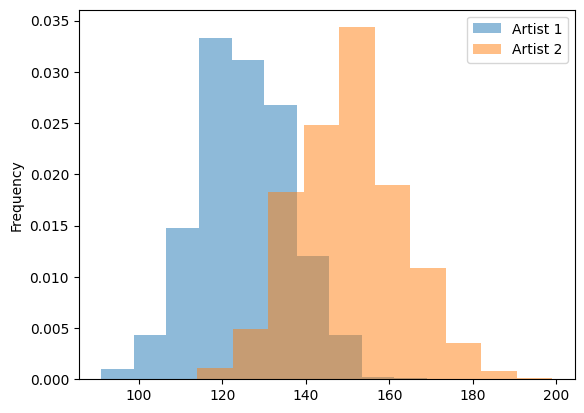

In [99]:
num_replicates = 1000

df = pd.DataFrame({
    "artist" : ['Artist 1'] * num_replicates + ['Artist 2']*num_replicates,
    "length" : np.concatenate((np.random.poisson(125,num_replicates),np.random.poisson(150,num_replicates)))
})

df.groupby('artist')['length'].plot(kind="hist",density=True,alpha=0.5,legend=True)

Since the lyrics may be stored with carriage returns or tabs, it may be useful to have a function that can collapse whitespace, using regular expressions, and be used for splitting. 

Q: What does the regular expression `'\s+'` match on? 

A: The regular expression above matches any length between 1 and unlimited times of white space character.


In [105]:
collapse_whitespace = re.compile(r'\s+')

def tokenize_lyrics(lyric) : 
    """strip and split on whitespace"""
    return(len([item.lower() for item in collapse_whitespace.split(lyric)]))

In [106]:
lyric_df['length'] = lyric_df['lyrics'].apply(tokenize_lyrics)

artist
cher     Axes(0.125,0.11;0.775x0.77)
robyn    Axes(0.125,0.11;0.775x0.77)
Name: length, dtype: object

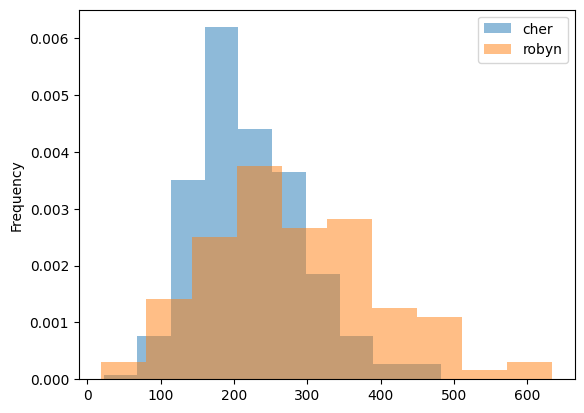

In [108]:
# Your lyric length comparison chart here.

lyric_df.groupby('artist')['length'].plot(kind="hist",density=True,alpha=0.5,legend=True)